In [ ]:
!pip install gym[atari]
!pip install autorom[accept-rom-license]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline

import gym
from gym.wrappers.record_video import RecordVideo
import itertools
import numpy as np
import os
import random
import sys
import matplotlib.pyplot as plt

if "../" not in sys.path:
  sys.path.append("../")

import tensorflow as tf
from collections import deque, namedtuple

/usr/local/lib/python3.10/dist-packages/jaxlib/xla_client.py:225: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  float8_e4m3b11fnuz = ml_dtypes.float8_e4m3b11


In [ ]:
environment = gym.envs.make("Breakout-v4", render_mode = 'rgb_array')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
VALID_ACTIONS = list(range(environment.action_space.n))

In [ ]:
def preprocess_images(imgs, offset_high = 34, offset_width = 0, target_height = 160, target_width = 160, output_dim = [84, 84], previous_state = None):
      output = tf.image.rgb_to_grayscale(imgs)
      output = tf.image.crop_to_bounding_box(output, offset_high, offset_width, target_height, target_width)
      output = tf.image.resize(
          output, output_dim, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
      output = tf.squeeze(output, axis=3)
      if previous_state == None:
        output = tf.stack([output] * 4, axis=3)
      else:
        output = tf.expand_dims(output, axis = 3)
        output = tf.concat((previous_state[:, :, :,1:], output[:, :, :, :]) , axis=3)
      return output

In [ ]:
input_dim = [ 84, 84, 4]
input = tf.keras.layers.Input(shape=input_dim)
x = tf.keras.layers.Conv2D(32, 8, 4, activation=tf.nn.relu)(input)
x = tf.keras.layers.Conv2D(64, 4, 2, activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(64, 3, 1, activation=tf.nn.relu)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512)(x)
output = tf.keras.layers.Dense(len(VALID_ACTIONS))(x)
qestimator = tf.keras.Model(inputs = input, outputs = output)
targetestimator = tf.keras.Model(inputs = input, outputs = output)

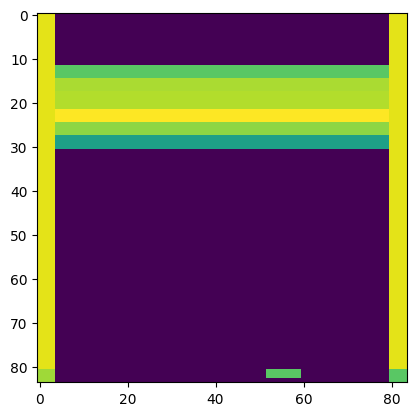

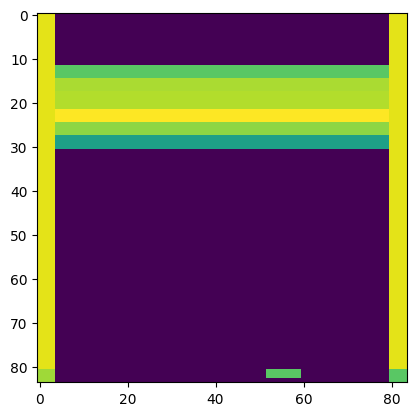

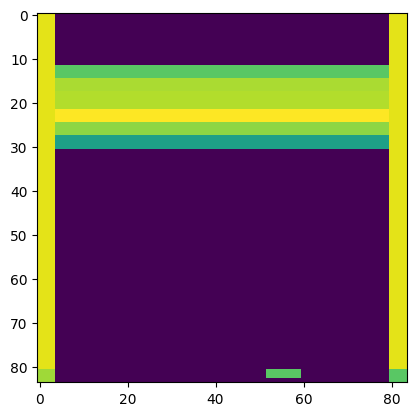

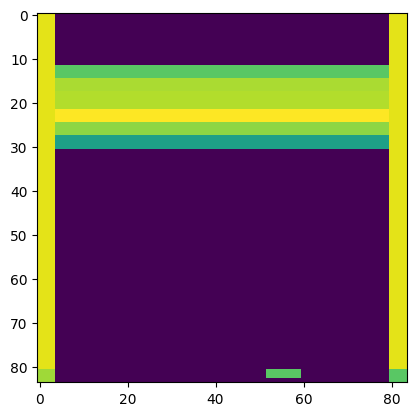

In [ ]:
observation = environment.reset()
observation = tf.expand_dims(observation, axis = 0)
obs = preprocess_images(observation)
for i in range(4):
  plt.figure()
  plt.imshow(obs[0, :,:,i])

In [ ]:
print(qestimator.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 84, 84, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 512)               1606144   
                                                                 
 dense_1 (Dense)             (None, 4)                 2052  

In [ ]:
@tf.function
def train_step(data, target, model, optimizer, loss_fn, batch_size, actions_taken):
    with tf.GradientTape() as tape:
        predictions = model(data, training=True)
        general_indxs = tf.cast(tf.range(batch_size) * tf.shape(predictions)[1], np.int64)
        gather_indices = general_indxs + actions_taken
        action_predictions = tf.gather(tf.reshape(predictions, [-1]), gather_indices)
        loss_value = loss_fn(target, action_predictions)
    grads = tape.gradient(loss_value, model.trainable_weights)
    print("ecco i gradienti da applicare ", grads)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    print(loss_value)
    return loss_value

In [ ]:
def make_epsilon_greedy_policy(estimator, nA):
    def policy_fn(observation, epsilon):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [ ]:
def set_directories(experiment_dir):
    monitor_path = os.path.join(experiment_dir, "monitor")
    if not os.path.exists(monitor_path):
        os.makedirs(monitor_path)
    return monitor_path

In [ ]:
def take_a_step(env, policy, curr_state,  timesteps_until_now, epsilon_decay_steps, epsilons, valid_actions):
    epsilon = epsilons[min(timesteps_until_now, epsilon_decay_steps-1)]
    action_probs = policy(curr_state, epsilon)
    action = np.random.choice(np.arange(len(valid_actions)), p=action_probs)
    next_state, reward, done, _ = env.step(valid_actions[action])
    next_state = tf.expand_dims(next_state, axis = 0)
    next_state = preprocess_images(next_state, previous_state = curr_state)
    return action, next_state, reward, done

In [ ]:
def reset_and_preprocess_env_state(env):
    state = env.reset()
    state = tf.expand_dims(state, axis = 0)
    return preprocess_images(state)

In [ ]:
def fill_replay_memory(env,
                      policy,
                      timesteps_until_now_f,
                      epsilon_decay_steps,
                      epsilons,
                      valid_actions,
                      replay_memory_size):
    replay_memory = []
    state = reset_and_preprocess_env_state(env)
    for i in range(replay_memory_size):
        action, next_state, reward, done = take_a_step(env,
                                                      policy,
                                                      state,
                                                      timesteps_until_now_f(),
                                                      epsilon_decay_steps,
                                                      epsilons,
                                                      valid_actions)
        replay_memory.append((state, action, reward, next_state, done))
        if done:
            state = reset_and_preprocess_env_state(env)
        else:
            state = next_state
    return replay_memory

In [ ]:
def training_loop(num_episodes,
                  env,
                  targetestimator,
                  qestimator,
                  timesteps_until_now_f,
                  update_target_estimator_every,
                  policy,
                  epsilon_decay_steps,
                  epsilons,
                  valid_actions,
                  replay_memory,
                  replay_memory_size,
                  batch_size,
                  discount_factor,
                  optimizer):
    for i_episode in range(num_episodes):
          state = reset_and_preprocess_env_state(env)
          loss = None
          for t in itertools.count():
              if timesteps_until_now_f() % update_target_estimator_every == 0:
                  targetestimator.set_weights(qestimator.get_weights())
              print("\rStep {} ({}) @ Episode {}/{}, loss: {}".format(
                      t, timesteps_until_now_f(), i_episode + 1, num_episodes, loss), end="")
              if len(replay_memory) == replay_memory_size:
                  replay_memory.pop(0)
              action, next_state, reward, done = take_a_step(env, policy, state,  timesteps_until_now_f(), epsilon_decay_steps, epsilons, valid_actions)
              replay_memory.append((state, action, reward, next_state, done))
              samples = random.sample(replay_memory, batch_size)
              states_batch, action_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))
              states_batch = tf.squeeze(states_batch, axis = 1)
              next_states_batch =  tf.squeeze(next_states_batch, axis = 1)
              q_values_next = targetestimator(next_states_batch)
              targets_batch = reward_batch + np.invert(done_batch).astype(np.float32) * discount_factor * np.amax(q_values_next, axis=1)
              loss = train_step(states_batch, targets_batch, qestimator, optimizer, loss_fn, batch_size, action_batch)
              if done:
                  break
              state = next_state

In [ ]:
def qlearning(qestimator,
              targetestimator,
              optimizer,
              env,
              loss_fn,
              valid_actions,
              experiment_dir,
              batch_size=64,
              discount_factor=0.99,
              num_episodes=430,
              record_video_every = 50,
              replay_memory_init_size=32000,
              epsilon_start=1.0,
              epsilon_end=0.1,
              epsilon_decay_steps=100000,
              update_target_estimator_every=10000,
              replay_memory_size=42000):
    targetestimator.set_weights(qestimator.get_weights())
    monitor_path = set_directories(experiment_dir)
    timesteps_until_now_f = lambda : optimizer.iterations.numpy()
    epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)
    policy = make_epsilon_greedy_policy(
        qestimator,
        len(valid_actions))
    replay_memory = fill_replay_memory(env,
                                      policy,
                                      timesteps_until_now_f,
                                      epsilon_decay_steps,
                                      epsilons,
                                      valid_actions,
                                      replay_memory_init_size)
    print("REPLAY MEMORY IS FILLED NOW")
    env = RecordVideo(env, video_folder = os.path.join(monitor_path, "video"),  episode_trigger = lambda episode_number: episode_number % record_video_every == 0)
    training_loop(num_episodes,
                  env,
                  targetestimator,
                  qestimator,
                  timesteps_until_now_f,
                  update_target_estimator_every,
                  policy,
                  epsilon_decay_steps,
                  epsilons,
                  valid_actions,
                  replay_memory,
                  replay_memory_size,
                  batch_size,
                  discount_factor,
                  optimizer)
    env.close()
    return "VIVA LA FIGA"

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(0.00025, 0.99, 0.0, 1e-6)
loss_fn = tf.keras.losses.MeanSquaredError()
experiment_dir = os.path.abspath("./experiments/{}".format(environment.spec.id))

qlearning(qestimator, targetestimator, optimizer, environment, loss_fn, VALID_ACTIONS, experiment_dir)


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


REPLAY MEMORY IS FILLED NOW


/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/experiments/Breakout-v4/monitor/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment Breakout-v4 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:297: UserWarning: WARN: No render fps was declared in the environment (env.metadata['re

Step 0 (0) @ Episode 1/430, loss: None

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


ecco i gradienti da applicare  [<tf.Tensor 'gradient_tape/model/conv2d/Conv2D/Conv2DBackpropFilter:0' shape=(8, 8, 4, 32) dtype=float32>, <tf.Tensor 'gradient_tape/model/conv2d/BiasAdd/BiasAddGrad:0' shape=(32,) dtype=float32>, <tf.Tensor 'gradient_tape/model/conv2d_1/Conv2D/Conv2DBackpropFilter:0' shape=(4, 4, 32, 64) dtype=float32>, <tf.Tensor 'gradient_tape/model/conv2d_1/BiasAdd/BiasAddGrad:0' shape=(64,) dtype=float32>, <tf.Tensor 'gradient_tape/model/conv2d_2/Conv2D/Conv2DBackpropFilter:0' shape=(3, 3, 64, 64) dtype=float32>, <tf.Tensor 'gradient_tape/model/conv2d_2/BiasAdd/BiasAddGrad:0' shape=(64,) dtype=float32>, <tf.Tensor 'gradient_tape/model/dense/MatMul/MatMul_1:0' shape=(3136, 512) dtype=float32>, <tf.Tensor 'gradient_tape/model/dense/BiasAdd/BiasAddGrad:0' shape=(512,) dtype=float32>, <tf.Tensor 'gradient_tape/model/dense_1/MatMul/MatMul_1:0' shape=(512, 4) dtype=float32>, <tf.Tensor 'gradient_tape/model/dense_1/BiasAdd/BiasAddGrad:0' shape=(4,) dtype=float32>]
Tensor("m

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment Breakout-v4 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Step 105 (13710) @ Episode 52/430, loss: 60358.73828125